In [0]:
#@title
%cd /content
!rm -rf remap_image
!git clone https://github.com/LanceNorskog/remap_image.git
%cd /content/remap_image
import scurve.scurve as scurve
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = "serif"
plt.set_cmap('tab20b')
plt.rcParams['figure.dpi'] = 100
import seaborn as sns
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d
from math import radians
from bokeh.io import export_png

/content
Cloning into 'remap_image'...
remote: Enumerating objects: 65, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (47/47), done.
remote: Total 65 (delta 28), reused 50 (delta 16), pack-reused 0
Unpacking objects: 100% (65/65), done.
/content/remap_image


<Figure size 432x288 with 0 Axes>

# Applications of Hilbert Space-Filling Curves to Image Processing

In [0]:
#@title
side = 8
power2 = int(2 ** np.floor(np.sqrt(side * 2)))
map = scurve.fromSize('hilbert', 2, power2 * power2)

def get_flyback(p1, p2):
    return abs(p2[0] - p1[0]) * side + abs(p2[1] - p1[1])

def get_manhattan(p1, p2):
    return abs(p2[0] - p1[0]) + abs(p2[1] - p1[1])

def get_euclid(p1, p2):
    return np.sqrt((p2[0] - p1[0]) * (p2[0] - p1[0]) + (p2[1] - p1[1]) * (p2[1] - p1[1]))


In a previous notebook, we demonstrated the concept of rearranging a matrix along the Hilbert Space-Filling Curve. In this notebook we will explain how to apply this operation to image processing. We will show how the self-similarity property of the Hilbert curve gives a very useful approach to sampling sections of an image, in particular to the way image processing works in deep learning.

Note that there are many space-filling curves. Empirical research has shown that the Hilbert curve is the best for our purposes. 

# Section 1: Hilbert space-filling curves as a matrix function

The following grids show how cells are numbered in a Hilbert path through an 8x8 grid. The left grid shows the conventional computer memory-based addressing. The right grid shows the path through the grid in cell order.

(These examples use an 8x8 grid to more completely display the interesting properties of neighborhood clusters in this technique.)

("Flyback" here refers to the distance between cells in memory. It is named for the "flyback transformer" found in cathode ray tubes. For more on this, [try out this wonderful tutorial](https://nationalmaglab.org/education/magnet-academy/watch-play/interactive/electromagnetic-deflection-in-a-cathode-ray-tube-ii).)

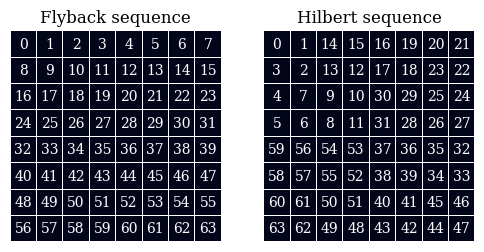

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Flyback sequence')
ax2.set_title('Hilbert sequence')
zeros = np.zeros((side, side))
ints = np.reshape(np.arange(side * side, dtype='int32'), (side, side))
mapper = np.zeros((side * side), dtype='int32')
for x in range(side):
    for y in range(side):
        xy = map.point(x * side + y)
        mapper[xy[0] * side + xy[1]] = x * side + y
mapped = np.reshape(mapper, (side, side))

sns.heatmap(zeros, ax=ax1, square=True, cbar=False, annot=ints, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(zeros, ax=ax2, square=True, cbar=False, annot=mapped, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Flyback sequence')
ax2.set_title('Hilbert sequence')
zeros = np.zeros((side, side))
ints = np.reshape(np.arange(side * side, dtype='int32'), (side, side))
mapper = np.zeros((side * side), dtype='int32')
for x in range(side):
    for y in range(side):
        xy = map.point(x * side + y)
        mapper[xy[0] * side + xy[1]] = x * side + y
mapped = np.reshape(mapper, (side, side))

sns.heatmap(zeros, ax=ax1, square=True, cbar=False, annot=ints, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(zeros, ax=ax2, square=True, cbar=False, annot=mapped, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

The Hilbert space-filling curve can be used as a function on a 2D matrix, which maps its cells to a new 2D matrix. This notebook illustrates this concept, and shows why it creates a useful method of sub-sampling neighborhoods in an image.

The following shows how sequences of cells in Flyback order are naturally clustered when mapped to Hilbert order. First, row-sized sequences and then somewhat randomized runs.

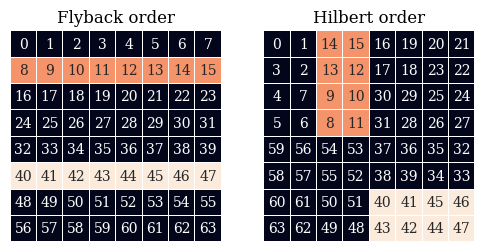

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Flyback order')
ax2.set_title('Hilbert order')

zeros = np.zeros((side * side))
zeros[8:16] = 0.7
zeros[40:48] = 0.9
zm = np.reshape(zeros[mapper], (side, side))

sns.heatmap(np.reshape(zeros, (side,side)), ax=ax1, square=True, cbar=False, annot=ints, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(zm, ax=ax2, square=True, cbar=False, annot=mapped, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

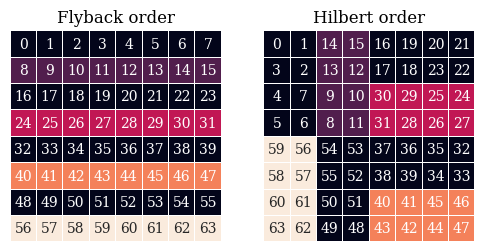

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Flyback order')
ax2.set_title('Hilbert order')

zeros = np.zeros((side * side))
for x in range(-side, side*side, side*2):
    zeros[x:x+(side)] = x + 5
zm = np.reshape(zeros[mapper], (side, side))

sns.heatmap(np.reshape(zeros, (side,side)), ax=ax1, square=True, cbar=False, annot=ints, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(zm, ax=ax2, square=True, cbar=False, annot=mapped, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

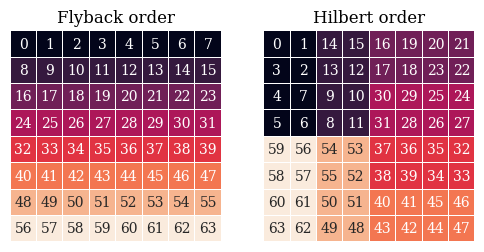

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Flyback order')
ax2.set_title('Hilbert order')

zeros = np.zeros((side * side))
for x in range(0, side*side, side):
    zeros[x:x+(side)] = x
zm = np.reshape(zeros[mapper], (side, side))

sns.heatmap(np.reshape(zeros, (side,side)), ax=ax1, square=True, cbar=False, annot=ints, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(zm, ax=ax2, square=True, cbar=False, annot=mapped, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

These sequences can be any range of cells in the matrix.

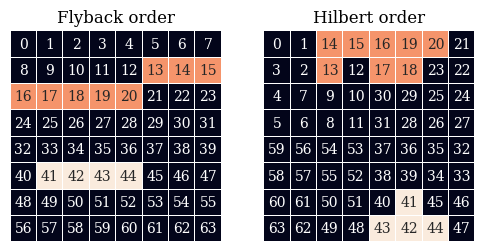

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Flyback order')
ax2.set_title('Hilbert order')

zeros = np.zeros((side * side))
zeros[13:21] = 0.7
zeros[41:45] = 0.9
z = np.reshape(zeros, (side, side))
zm = np.reshape(zeros[mapper], (side, side))

sns.heatmap(z, ax=ax1, square=True, cbar=False, annot=ints, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(zm, ax=ax2, square=True, cbar=False, annot=mapped, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

Obviously, these data subsets are *not* probabilistic samples- no coins were tossed, no dice were thrown.
However, copying cells from the Flyback sequence to the corresponding Hilbert cluster is a form of sampling that look suspiciously like probabilistic sampling. 

Also, these clusters are not always contiguous, as you can see in the following sample (cells 45 through 49, orange).

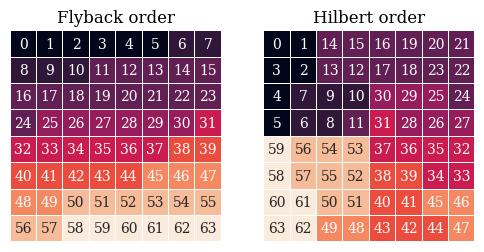

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Flyback order')
ax2.set_title('Hilbert order')

zeros = np.zeros((side * side))
i = 0
d = 0
for bound in [6, 11, 25, 31, 38, 45, 50, 58, 64]:
    color = d
    #if d % 2 == 0:
    #    color = -(d + 1)
    while i < bound:
        zeros[i] = color
        i += 1
    d += 1

zm = np.reshape(zeros[mapper], (side, side))
sns.heatmap(np.reshape(zeros, (side,side)), ax=ax1, square=True, cbar=False, annot=ints, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(zm, ax=ax2, square=True, cbar=False, annot=mapped, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

# Section 2: Euclidean Distances of Flyback and Hilbert Matrices

These are [heatmaps](https://seaborn.pydata.org/examples/heatmap_annotation.html) of the Euclidean difference between all pairs of cells in the Flyback-ordered and Hilbert-ordered matrices, along the Flyback and Hilbert paths. On the left, Euclidean distances for the conventionally numbered matrix. On the right, the Euclidean distance between all pairs following the sequence of the space-filling curve. That is, on the left are the Euclidean distances for standard row order, and on the right are the Euclidean distances between two cells on the Hilbert path.

In [0]:
#@title

# viz: seaborn heat maps, distance from x,y to hilbert(x,y)
flyback_heatmap = np.zeros((side * side, side * side))
euclid_heatmap = np.zeros((side * side, side * side))
hilbert_heatmap = np.zeros((side * side, side * side))
hilbert_map = [[]] * side
euclid_tri = []
hilbert_tri = []
for x1 in range(side):
    hilbert_map[x1] = [[]] * side
    for y1 in range(side):
        hilbert_map[x1][y1] = map.point(x1 * side + y1)
        for x2 in range(side):
            for y2 in range(side):
                p1 = (x1, y1)
                p2 = (x2, y2)
                flyback_heatmap[x1 * side + y1, x2 * side + y2] = get_flyback(p1, p2)
                euclid_heatmap[x1 * side + y1, x2 * side + y2] = get_euclid(p1, p2)
                h1 = map.point(x1 * side + y1)
                h2 = map.point(x2 * side + y2)
                hilbert_heatmap[x1 * side + y1, x2 * side + y2] = get_euclid(h1, h2)
                if x1 < x2 and y1 < y2:
                    euclid_tri.append(get_euclid(p1, p2))
                    hilbert_tri.append(get_euclid(h1, h2))

euclid_tri = np.array(euclid_tri)
hilbert_tri = np.array(hilbert_tri)


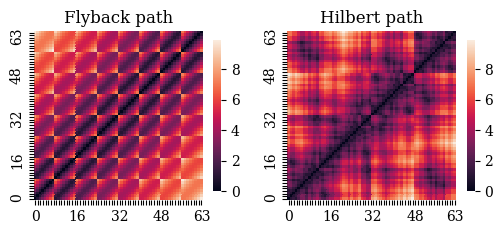

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Flyback path')
ax2.set_title('Hilbert path')
ticks = [''] * (side * side)
ticks[side * side - 1] = str(side * side - 1)
for x in range(0, side * side, side*2):
    ticks[x] = str(x)
rev = np.arange(side * side - 1, -1, -1, dtype='int32')
xticks = np.array(ticks)
yticks = np.array(ticks)[rev]

sns.heatmap(euclid_heatmap[rev][:], ax=ax1, square=True, cbar=True, cbar_kws={'shrink': 0.5}, xticklabels=xticks, yticklabels=yticks)
sns.heatmap(hilbert_heatmap[rev][:], ax=ax2, square=True, cbar=True, cbar_kws={'shrink': 0.5}, xticklabels=xticks, yticklabels=yticks)

plt.show()

From the above right, we can see that the distance along the Hilbert path is (somewhat) correlated with the Euclidean distance between two points. (Although, the farthest corners are also close to each other- the Hilbert path is somewhat "looped".

Next, we will divide the Flyback distances by the Hilbert distances. Note that the Flyback distance mostly ranges from 1.5x to 3x the Hilbert, with some outliers.


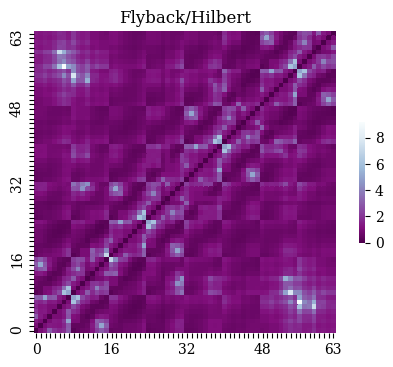

In [0]:
#@title

fig, (ax1) = plt.subplots(1, 1)
ax1.set_title('Flyback/Hilbert')
ticks = [''] * (side * side)
ticks[side * side - 1] = str(side * side - 1)
for x in range(0, side * side, side*2):
    ticks[x] = str(x)
rev = np.arange(side * side - 1, -1, -1, dtype='int32')
xticks = np.array(ticks)
yticks = np.array(ticks)[rev]

sns.heatmap((euclid_heatmap[rev][:])/(hilbert_heatmap[rev][:] + 0.001), cbar_kws={'shrink': 0.4}, ax=ax1, square=True, cbar=True, cmap="BuPu_r", 
            xticklabels=xticks, yticklabels=yticks)
plt.show()

# Section 3: Cluster Size Distributions

Now, let's take a look at the sizes of these sampled clusters. We're going to map sequences of cells from Flyback to Hilbert order, and analyze the sizes of the resulting cell clusters.
This dataset is a portrait of the locality of these 2-dimensional neighborhood samples.

In [0]:
#@title
scan=side
ind = np.arange(scan)
distances_pixel = []
distances_row = []
dist_pixel_x = []
dist_pixel_y = []
dist_row_x = []
dist_row_y = []
for i in range(0, side*side + 1 - scan, 1):
    points = []
    for j in range(scan):
        points.append(map.point(i + j))
    c = np.mean(points, axis=0)
    for j in range(0, scan):
        dist = get_euclid(points[j], c)
        distances_pixel.append(dist)
        dist_pixel_x.append(points[j][0] - c[0])
        dist_pixel_y.append(points[j][1] - c[1])
        if i % side == 0:
            distances_row.append(dist)
            dist_row_x.append(points[j][0] - c[0])
            dist_row_y.append(points[j][1] - c[1])


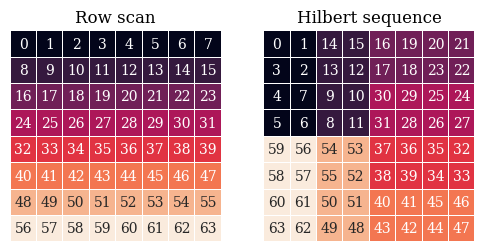

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Row scan')
ax2.set_title('Hilbert sequence')

zeros = np.zeros((side * side))
for x in range(0, side*side, side):
    zeros[x:x+(side)] = x
zm = np.reshape(zeros[mapper], (side, side))

sns.heatmap(np.reshape(zeros, (side,side)), ax=ax1, square=True, cbar=False, annot=ints, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(zm, ax=ax2, square=True, cbar=False, annot=mapped, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

Let's take this row-by-row sampling of an 8x8 grid when mapped to Hilbert space, and:
* calculate the centroid of the sample cluster
* calculate the Euclidean distance from each cell to the centroid.


First, a simple plot of these distances, with a grid for reference.

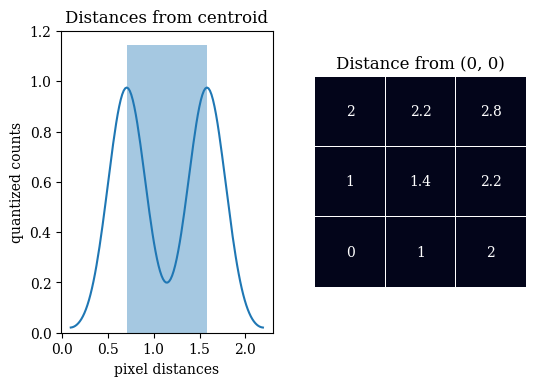

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Distances from centroid')
ax2.set_title('Distance from (0, 0)')

ax1.set_xlabel('pixel distances')
ax1.set_ylabel('quantized counts')
#ax1.set_yticks([])
#ax1.set_aspect(1.0)
sns.distplot(np.abs(np.array(distances_row)), ax=ax1, kde=True)

z9 = np.zeros((3,3), dtype='int32')
markers = np.array([[2.0, 2.2, 2.8], [1.0, 1.414, 2.2], [0.0, 1.0, 2.0]])
sns.heatmap(z9, ax=ax2, square=True, cbar=False, annot=markers, 
                 xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
plt.show()

This is a scatter plot of the distances, with 2D information preserved.

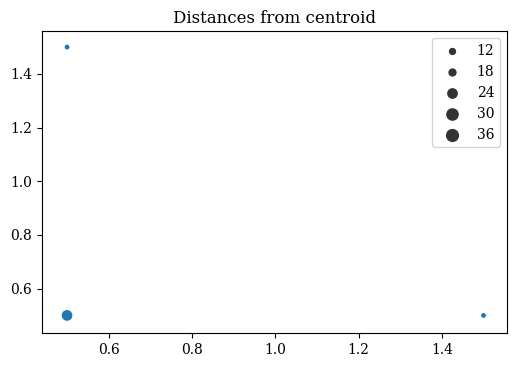

In [0]:
#@title
trans = np.transpose([np.abs(dist_row_x), np.abs(dist_row_y)])
(dist,counts) = np.unique(trans, return_counts=True, axis=0)
fig, (ax1) = plt.subplots(1, 1)
distx = np.transpose(dist)[0]
disty = np.transpose(dist)[1]
ax1.set_title('Distances from centroid')

sns.scatterplot(distx, disty, ax=ax1,
                 cmap="Reds", size=counts)
plt.show()

Next, we're going to march through the 8x8 cube one *cell* at a time, and collect the same measurements. That is, we're going to march a row of cells through the matrix in Flyback order, capture the positions of those cells in the Hilbert version of the matrix, and take the distance from the centroid of all 63 
row-length. (Here are 6 examples of the 63 rows and their corresponding 
clusters.)

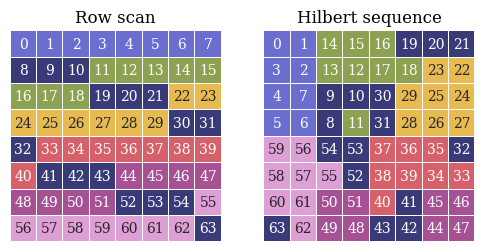

In [0]:
#@title 
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Row scan')
ax2.set_title('Hilbert sequence')

zeros = np.zeros((side * side))
zeros[0:8] = 0.1
zeros[11:19] = 0.2
zeros[22:30] = 0.4
zeros[33:41] = 0.6
zeros[44:52] = 0.7
zeros[55:63] = 0.8
z = np.reshape(zeros, (side, side))
zm = np.reshape(zeros[mapper], (side, side))

sns.heatmap(z, ax=ax1, cmap='tab20b', square=True, cbar=False, annot=ints, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
sns.heatmap(zm, ax=ax2, cmap='tab20b', square=True, cbar=False, annot=mapped, xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')

plt.show()

Note that the row-wise walk of the matrix (above) always creates clustered neighborhoods, while the off-register walk often generates larger, sparser, and often non-contiguous neighborhoods.

As a result, the row-wise walk distances are limited to below 2.5, while the off-register walk distances range to 5.

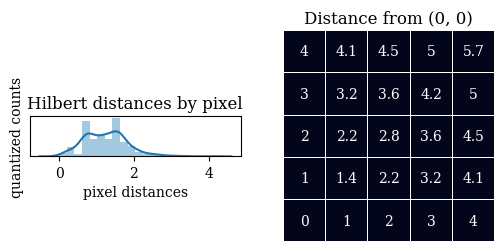

In [0]:
#@title
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.set_title('Hilbert distances by pixel')
ax2.set_title('Distance from (0, 0)')

ax1.set_xlabel('pixel distances')
ax1.set_ylabel('quantized counts')

ax1.set_yticks([])
ax1.set_aspect(1.0)
sns.distplot(np.array(distances_pixel), ax=ax1)

z9 = np.zeros((5,5), dtype='int32')
markers = np.zeros((5,5))
for i in range(5):
    for j in range(5):
        markers[4-i,j] = get_euclid([0,0],[i,j])
sns.heatmap(z9, ax=ax2, square=True, cbar=False, annot=markers, 
                 xticklabels=False, yticklabels=False, linewidths=0.01, linecolor='white')
plt.show()

Let's do a scatterplot of this larger dataset, and since the data has lot more variation, we will also also a KDE (kernel density estimation) plot. The scatterplot is good for seeing the structure of outliers, while the KDE plot is a portrait of the main structure.

129 129 129


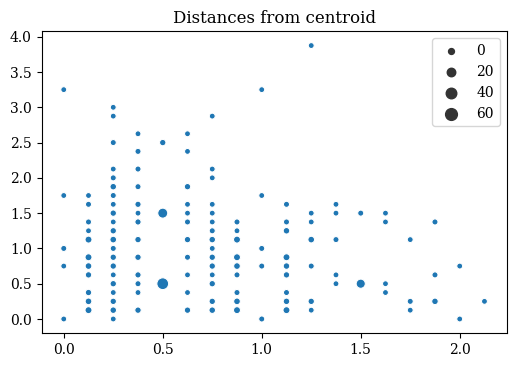

In [0]:
#@title
trans = np.transpose([np.abs(dist_pixel_x), np.abs(dist_pixel_y)])
(dist,counts) = np.unique(trans, return_counts=True, axis=0)
fig, (ax1) = plt.subplots(1, 1)
distx = np.transpose(dist)[0]
disty = np.transpose(dist)[1]
ax1.set_title('Distances from centroid')

print(len(distx), len(disty), len(counts))
sns.scatterplot(distx, disty, ax=ax1,
                 cmap="Reds", size=counts)
plt.show()

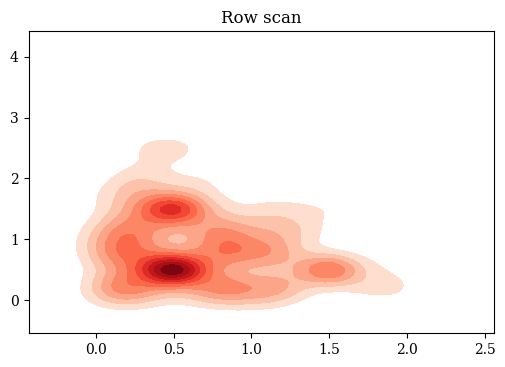

In [0]:
#@title
fig, (ax1) = plt.subplots(1, 1)
ax1.set_title('Row scan')
#ax1.set_aspect(0.1)
sns.kdeplot(np.abs(dist_pixel_x), np.abs(dist_pixel_y), ax=ax1,
                 cmap="Reds", shade=True, shade_lowest=False)
plt.show()

# Appendix: More on space-filling curves

There are many kinds of space-filling curve, but they are generally based on the mathematics of folding paper in half multiple times, then cutting the resulting (thick) piece of paper. (I found one illustration of exactly this, but now cannot locate it.)



Empirical research has shown that the Hilbert curve has the best locality. Here is two such investigations:

[Analysis_of_the_Clustering_Properties_of_Hilbert_Space-filling_Curve](https://www.researchgate.net/publication/3296936_Analysis_of_the_Clustering_Properties_of_Hilbert_Space-filling_Curve)

[The Performance of Space-Filling Curves for Dimension Reduction](https://people.csail.mit.edu/jaffer/CNS/PSFCDR)